In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os


In [2]:
# Define base paths
data_dir = "../../data/loaded"
Images_dir = "../../images/processing_1"
processed_data_dir = "../../data/processed"
climate_file_path = os.path.join(data_dir, "climate.csv")

In [3]:
clim_df = pd.read_csv(climate_file_path)

# by month stats

In [4]:
# first get range (interval) of each column
for col in clim_df.select_dtypes(include=[np.number]).columns:
    col_min = clim_df[col].min()
    col_max = clim_df[col].max()
    print(f"Column: {col}, Min: {col_min}, Max: {col_max}")

Column: time, Min: 1, Max: 12
Column: lat, Min: 19.04166666666667, Max: 37.29166666666667
Column: lon, Min: -8.625, Max: 11.958333333333332
Column: prec, Min: 0.0, Max: 266.15
Column: tmin, Min: -2.25, Max: 32.0
Column: tmax, Min: 5.25, Max: 48.0


In [8]:
(clim_df.groupby(['lon','lat','time']).size() > 1).sum()


np.int64(0)

In [10]:
window = 3  # 3-month rolling window

# Sort and copy
clim_df_sorted = clim_df.sort_values(['lon','lat','time']).copy()

# Duplicate last months for wrap-around
wrap_df = clim_df_sorted[clim_df_sorted['time'] > 12 - (window-1)].copy()
wrap_df['time'] = wrap_df['time'] - 12
clim_df_extended = pd.concat([wrap_df, clim_df_sorted], ignore_index=True)

# Rolling median per location
rolling_list = []

for (lon, lat), group in clim_df_extended.groupby(['lon','lat']):
    group = group.sort_values('time')
    group_rolling = group[['time','prec','tmin','tmax']].rolling(window=window, on='time').median()
    group_rolling['lon'] = lon
    group_rolling['lat'] = lat
    rolling_list.append(group_rolling)

rolling_features = pd.concat(rolling_list, ignore_index=True)

# Merge rolling features with original monthly values
final_features = clim_df_sorted.merge(
    rolling_features[['lon','lat','time','prec','tmin','tmax']].rename(
        columns={'prec':'prec_median_3m', 'tmin':'tmin_median_3m', 'tmax':'tmax_median_3m'}
    ),
    on=['lon','lat','time'],
    how='left'
)


In [11]:
final_features.head()

,time,lat,lon,prec,tmin,tmax,prec_median_3m,tmin_median_3m,tmax_median_3m
0,1,27.291667,-8.625,2.000,8.00,22.00,4.1,8.0,22.0
1,2,27.291667,-8.625,0.425,11.00,25.00,2.0,8.0,22.0
2,3,27.291667,-8.625,0.500,13.00,27.00,0.5,11.0,25.0
3,4,27.291667,-8.625,1.500,18.00,32.00,0.5,13.0,27.0
4,5,27.291667,-8.625,0.000,19.25,33.25,0.5,18.0,32.0


In [12]:
# print intervals of new features
for col in ['prec_median_3m', 'tmin_median_3m', 'tmax_median_3m']:
    col_min = final_features[col].min()
    col_max = final_features[col].max()
    print(f"Column: {col}, Min: {col_min}, Max: {col_max}")

Column: prec_median_3m, Min: 0.0, Max: 217.125
Column: tmin_median_3m, Min: -1.25, Max: 31.0
Column: tmax_median_3m, Min: 6.25, Max: 46.75


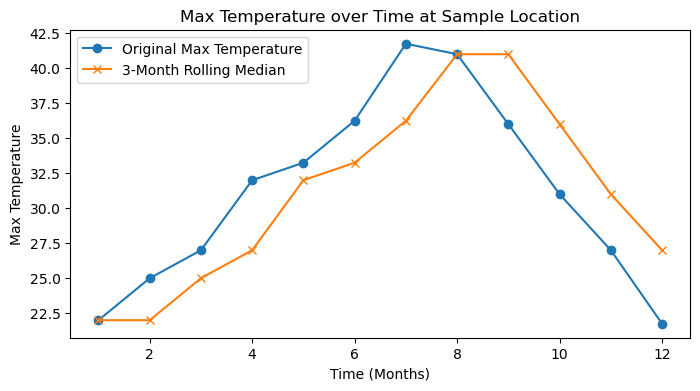

In [14]:
# plot one location's data to visualize rolling median (tmax)
sample_location = final_features[(final_features['lon'] == final_features['lon'].iloc[0]) & (final_features['lat'] == final_features['lat'].iloc[0])]
plt.figure(figsize=(8, 4))
plt.plot(sample_location['time'], sample_location['tmax'], label='Original Max Temperature', marker='o')
plt.plot(sample_location['time'], sample_location['tmax_median_3m'], label='3-Month Rolling Median', marker='x')
plt.xlabel('Time (Months)')
plt.ylabel('Max Temperature')
plt.title('Max Temperature over Time at Sample Location')
plt.legend()
plt.show()  

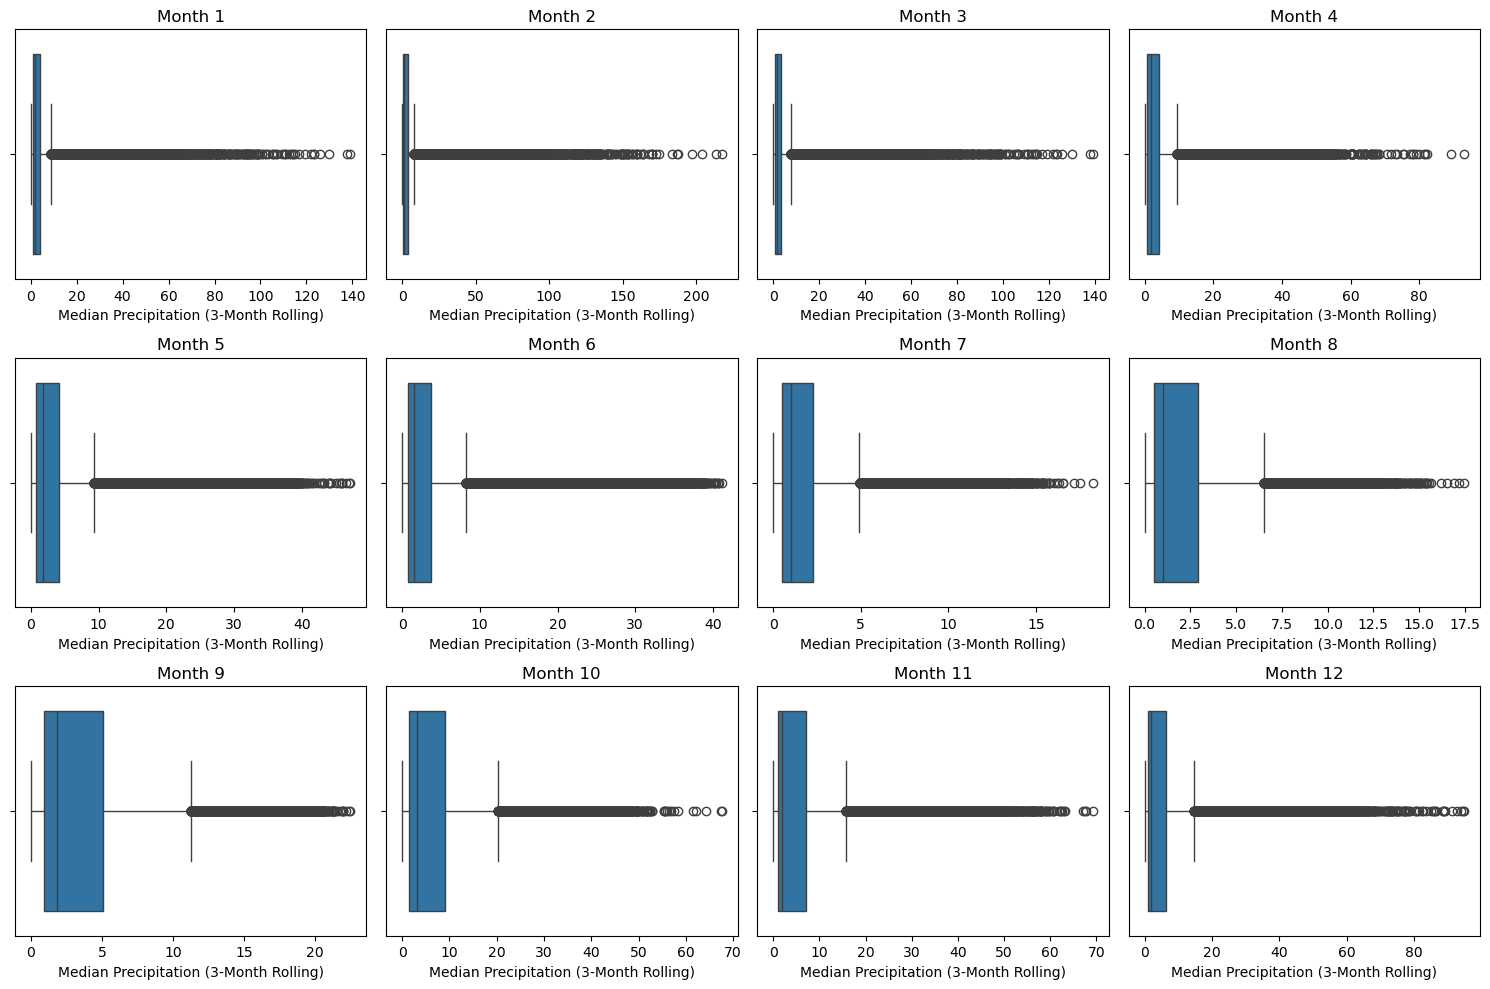

In [19]:
# plot distribution of median precipitation through months with horizontal boxplot for each month (3X4 grid of subplots )
axes = []
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharey=True)
for month in range(1, 13):
    ax = axs[(month-1)//4, (month-1)%4]
    sns.boxplot(
        x='prec_median_3m',
        data=final_features[final_features['time'] == month],
        ax=ax
    )
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Median Precipitation (3-Month Rolling)')
    axes.append(ax)
plt.tight_layout()
plt.show()

# save 

In [20]:
final_features.to_csv(os.path.join(processed_data_dir, "climate_processed.csv"), index=False)

# Aggregate month -> season

In [4]:
clim_df.head()

,time,lat,lon,prec,tmin,tmax
0,1,37.291667,9.541667,48.075,8.50,16.50
1,1,37.291667,9.625000,45.525,8.25,16.75
2,1,37.291667,9.708333,42.900,8.25,16.75
3,1,37.291667,9.791667,40.975,8.25,17.00
4,1,37.208333,9.208333,54.350,9.00,17.00


In [5]:
clim_df.columns

Index(['time', 'lat', 'lon', 'prec', 'tmin', 'tmax'], dtype='object')

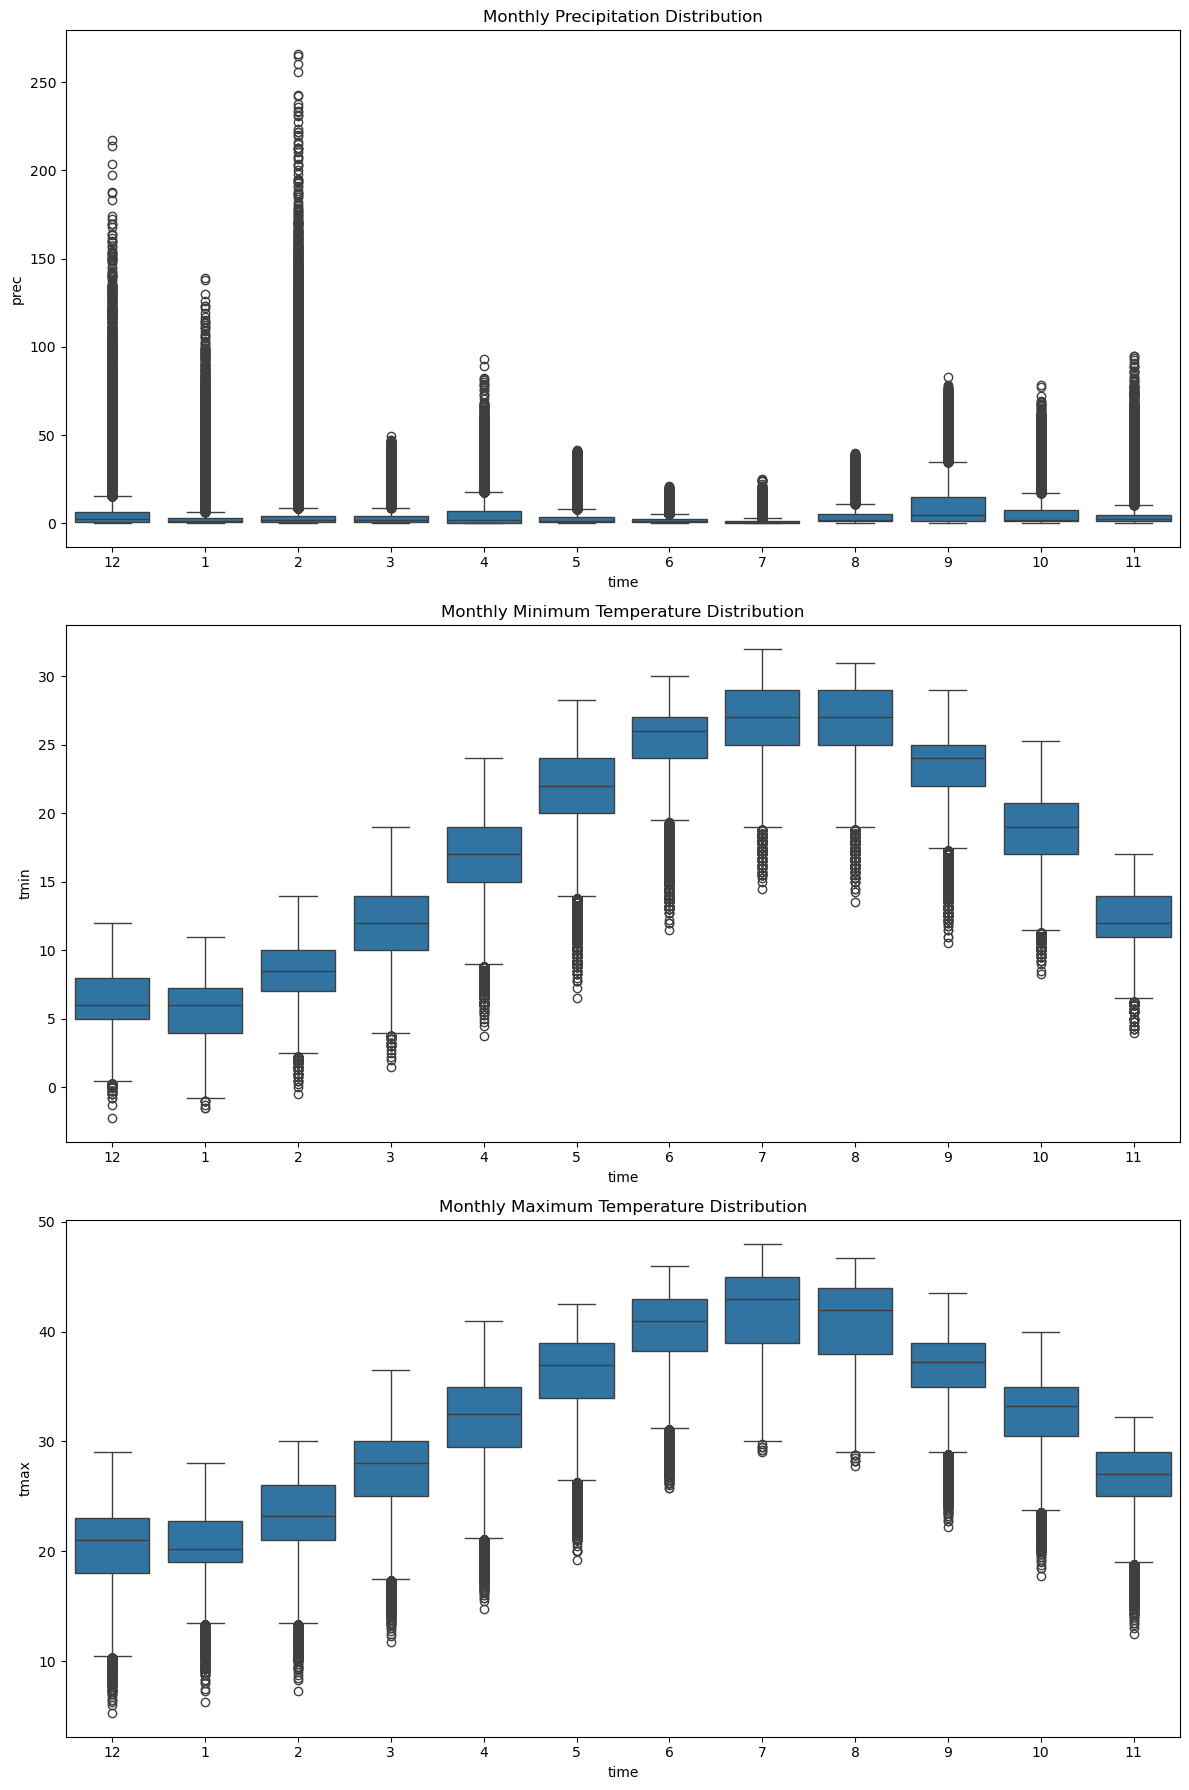

In [ ]:
# plot boxplots of climate variables by month , starting by month 12 to month 11

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
sns.boxplot(x='time', y='prec', data=clim_df, ax=axes[0], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
axes[0].set_title('Monthly Precipitation Distribution')
sns.boxplot(x='time', y='tmin', data=clim_df, ax=axes[1], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
axes[1].set_title('Monthly Minimum Temperature Distribution')
sns.boxplot(x='time', y='tmax', data=clim_df, ax=axes[2], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
axes[2].set_title('Monthly Maximum Temperature Distribution')
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, 'climate_boxplots_by_month.png'))
plt.show()


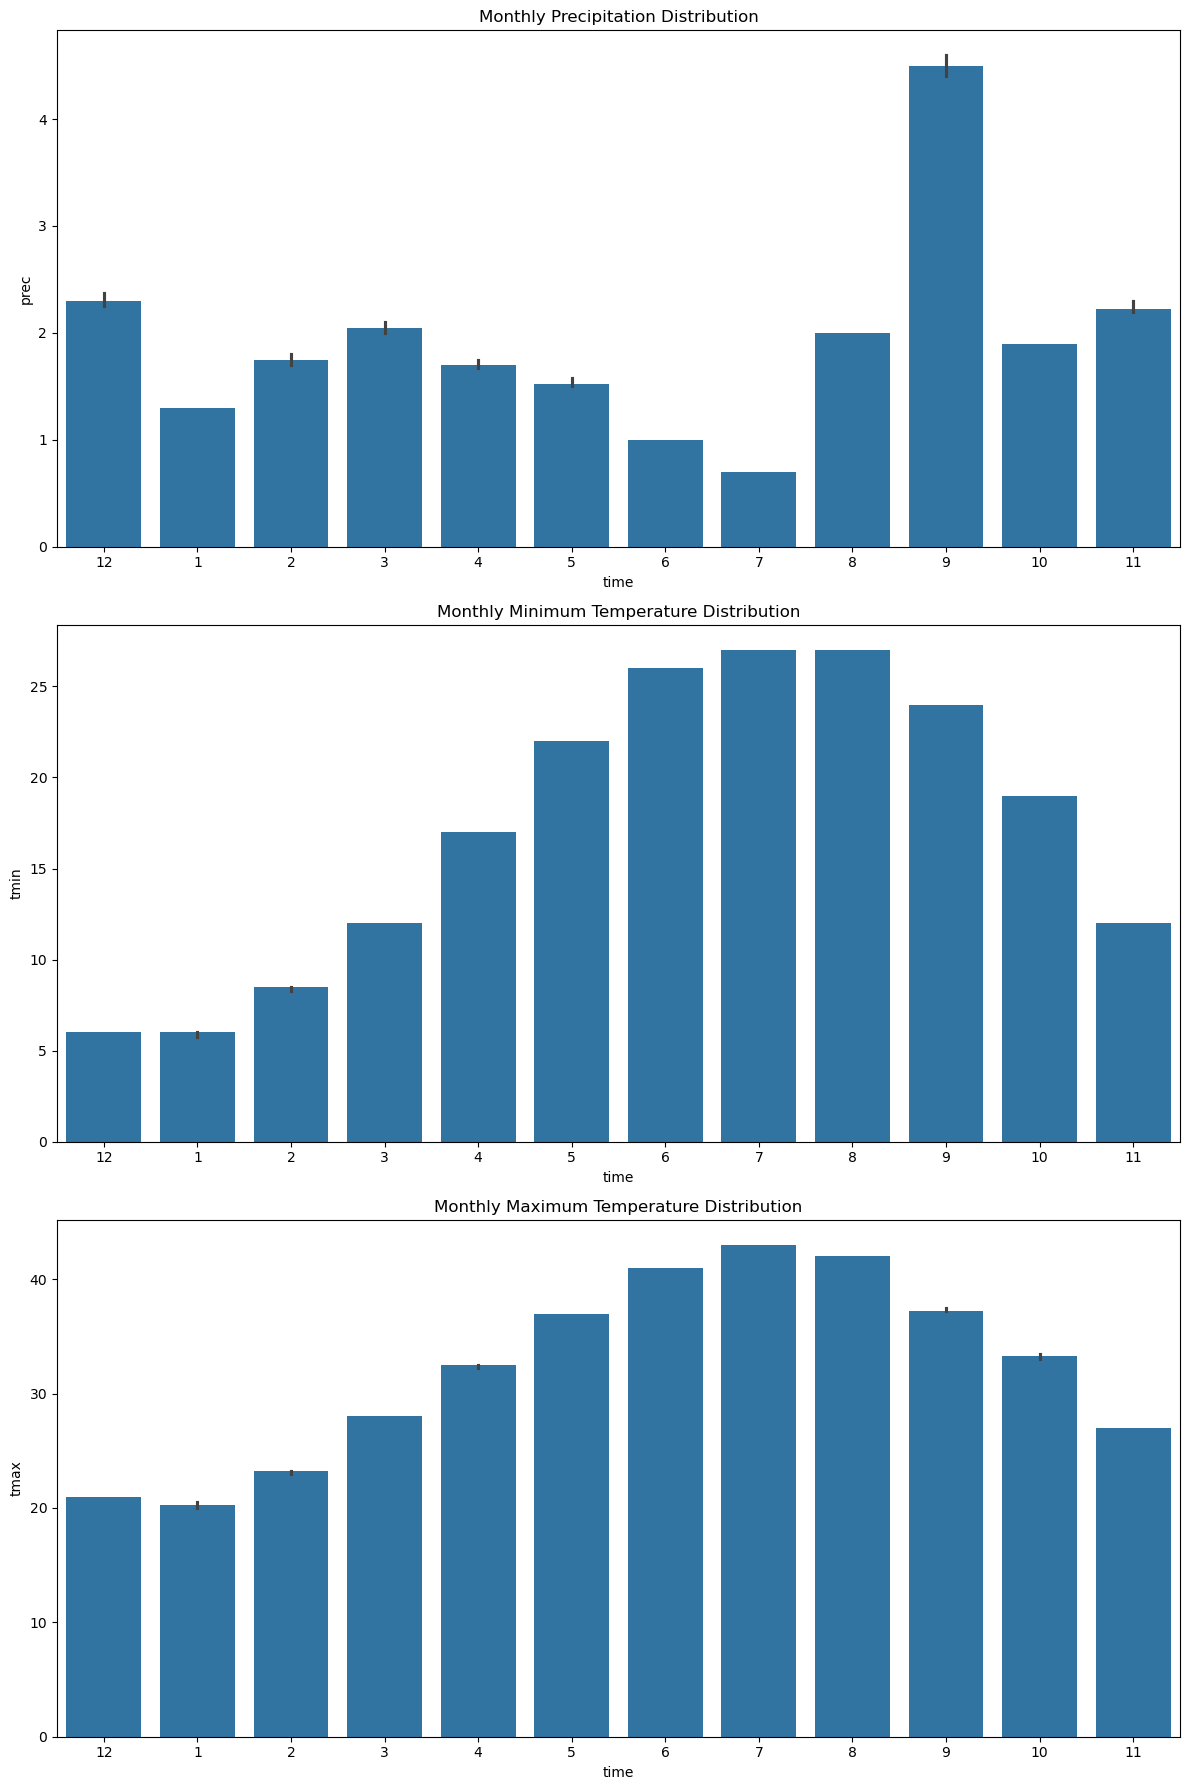

In [ ]:
# plot barplot of median of climate variables by month , starting by month 12 to month 11

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
sns.barplot(x='time', y='prec', data=clim_df, ax=axes[0], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], estimator=np.median)
axes[0].set_title('Monthly Precipitation Distribution')
sns.barplot(x='time', y='tmin', data=clim_df, ax=axes[1], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], estimator=np.median)
axes[1].set_title('Monthly Minimum Temperature Distribution')
sns.barplot(x='time', y='tmax', data=clim_df, ax=axes[2], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], estimator=np.median)
axes[2].set_title('Monthly Maximum Temperature Distribution')
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, 'climate_barplots_by_month.png'))
plt.show()


### trying to remove outliers

In [28]:
# Create filtered monthly dataframes
filtered_monthly = []

for month in clim_df['time'].unique():
    month_df = clim_df[clim_df['time'] == month]
    
    # Compute IQR for this month
    Q1 = month_df[['prec', 'tmin', 'tmax']].quantile(0.25)
    Q3 = month_df[['prec', 'tmin', 'tmax']].quantile(0.75)
    IQR = Q3 - Q1
    
    # Remove rows where any variable is an outlier
    month_df_filtered = month_df[~((month_df[['prec', 'tmin', 'tmax']] < (Q1 - 1.5*IQR)) |
                                   (month_df[['prec', 'tmin', 'tmax']] > (Q3 + 1.5*IQR))).any(axis=1)]
    
    filtered_monthly.append(month_df_filtered)

# Concatenate all filtered months
clim_df_no_outliers = pd.concat(filtered_monthly, ignore_index=True)

print("Original shape:", clim_df.shape)
removed_count = clim_df.shape[0] - clim_df_no_outliers.shape[0]
removed_pct = round(removed_count / clim_df.shape[0] * 100, 2)
print("Removed rows:", removed_count, f"({removed_pct}%)")
print("New shape:", clim_df_no_outliers.shape)

Original shape: (395124, 6)
Removed rows: 50819 (12.86%)
New shape: (344305, 6)


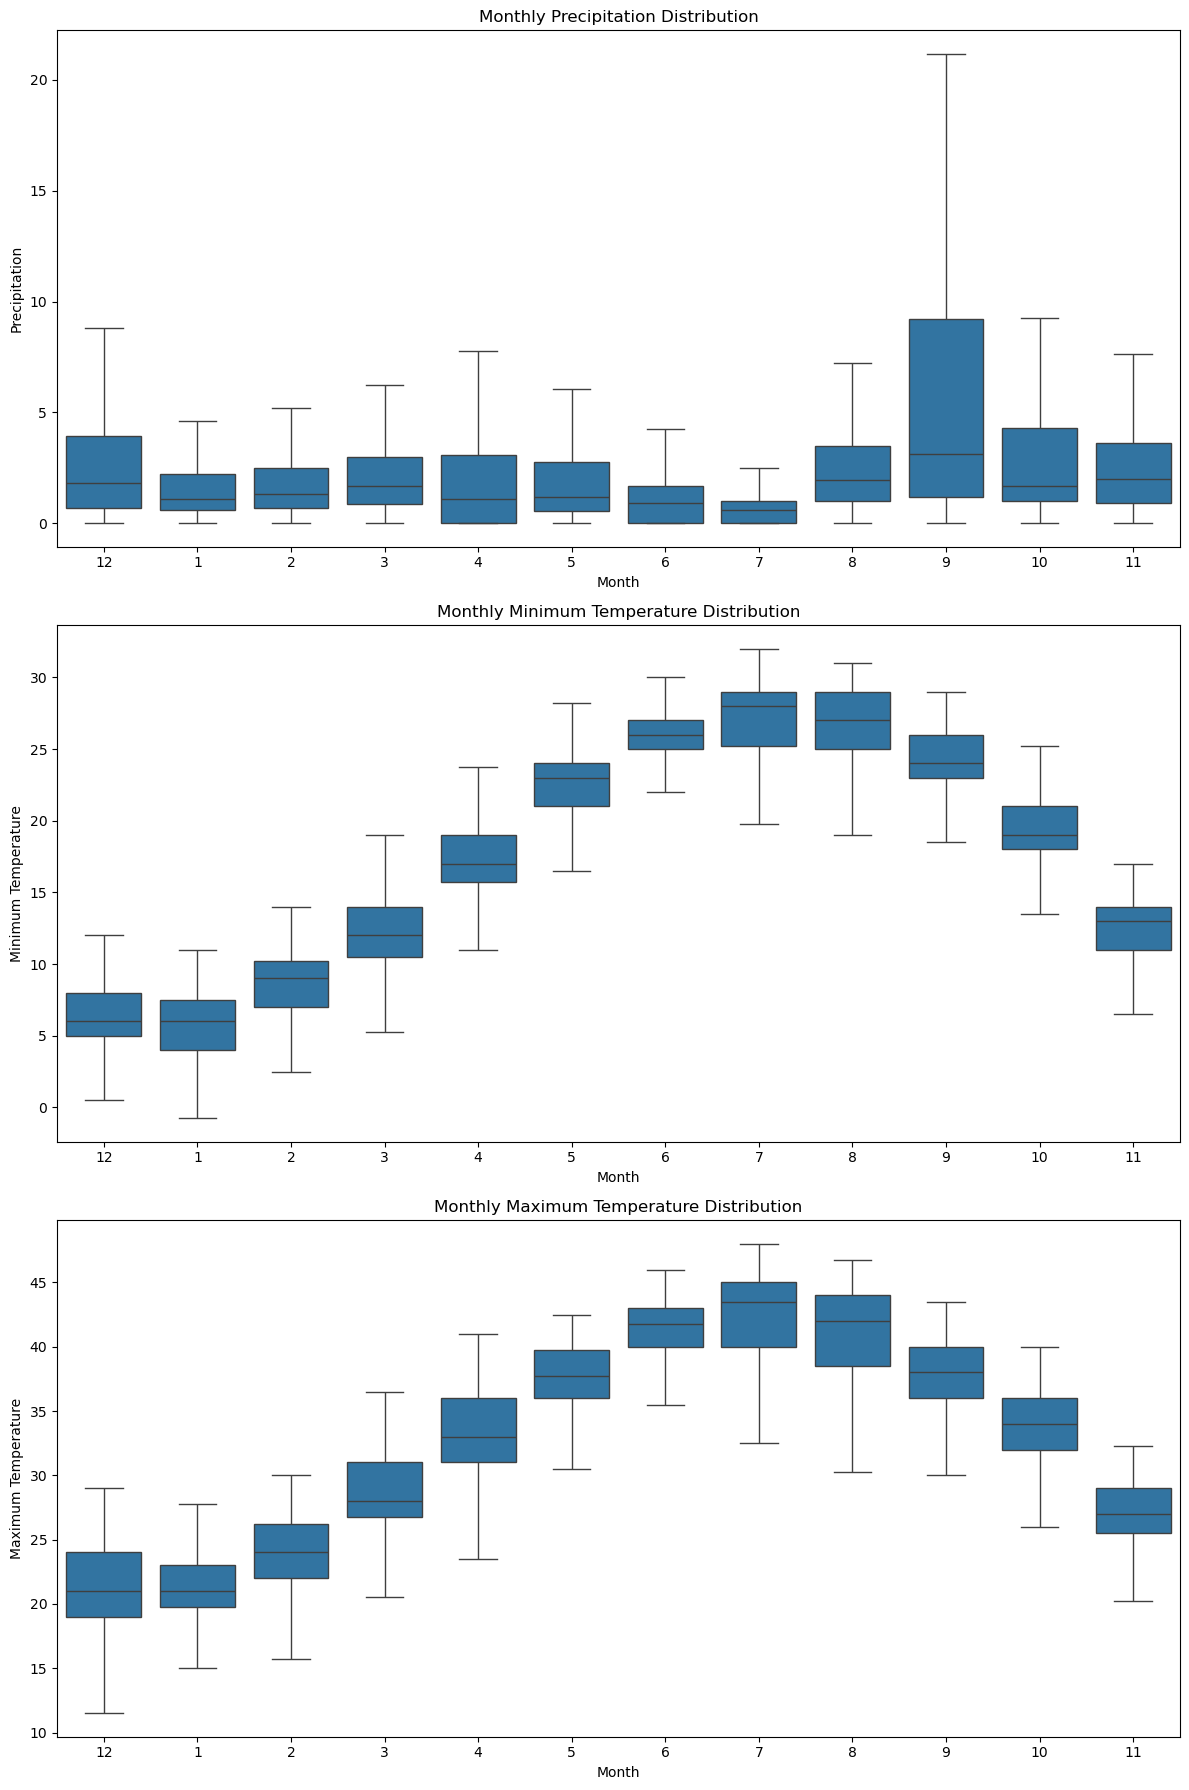

In [ ]:
# plot boxplots of climate variables by month , starting by month 12 to month 11 for clim_df_no_outliers

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
sns.boxplot(x='time', y='prec', data=clim_df_no_outliers, ax=axes[0], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
axes[0].set_title('Monthly Precipitation Distribution')
sns.boxplot(x='time', y='tmin', data=clim_df_no_outliers, ax=axes[1], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
axes[1].set_title('Monthly Minimum Temperature Distribution')
sns.boxplot(x='time', y='tmax', data=clim_df_no_outliers, ax=axes[2], order=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
axes[2].set_title('Monthly Maximum Temperature Distribution')
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, 'climate_boxplots_by_month_no_outliers.png'))
plt.show()
